### Detecting suicide ideation in online posts from Twitter using Machine Learning classifiers

In [1]:
!pip install  unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.8 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
# AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pickle
import string
import re
import unidecode

# Text Processing libraries
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
df = pd.read_csv('Suicide_Ideation_Twitter.csv',encoding='utf-8',engine='python')

print(df.shape)

# df = df.sample(6000, random_state=47)
# df.drop('Unnamed: 0', axis=1,inplace=True)
df.head()

(1787, 2)


,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post


In [4]:
df.rename(columns={'Tweet':'text','Suicide':'class'},inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1785 non-null   object
 1   class   1787 non-null   object
dtypes: object(2)
memory usage: 28.0+ KB


In [6]:
df['text'] = df['text'].astype(str)
df['class'] = df['class'].astype(str)
df['text'] = df['text'].str.lower()
df['class'] = df['class'].str.lower()

In [7]:
df.reset_index(inplace=True,drop=True)

In [8]:
df[df['text'].isnull()].index

Index([], dtype='int64')

In [9]:
df.to_csv('suicide_detection_twitter_modified.csv')

In [10]:
def rem_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

def rem_url(text):
    return re.sub(r'http\S+', '', text)

def rem_email(text):
    return re.sub(r'\S+@\S+', '', text)

def rem_symbols_digits(text):
    return re.sub('[^a-zA-Z\s]', ' ', text)

def rem_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def rem_special(text):
    return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

def rem_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def fix_lengthening(text):
     return re.sub(r"(.)\1{2,}",r'\1',text)


In [11]:
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
# Looking at a sample tweet
df['text'][30]

"@domselinakyle that sounds so terrible that's how i was when my dad still lived w me but i hope it gets better forâ\x80¦ https://t.co/oah2tunbxt"

In [13]:
df['text']   = df['text'].apply(lambda t : rem_emoji(t))
df['text']   = df['text'].apply(lambda t : rem_symbols_digits(t))
df['text']   = df['text'].apply(lambda t : rem_url(t))
df['text']   = df['text'].apply(lambda t : rem_email(t))
df['text']   = df['text'].apply(lambda t : rem_special(t))
df['text']   = df['text'].apply(lambda t : rem_accented_chars(t))
df['text']   = df['text'].apply(lambda t : fix_lengthening(t))
df['text']   = df['text'].apply(lambda t : rem_whitespace(t))

In [14]:
df['text'][30]

'domselinakyle that sounds so terrible that s how i was when my dad still lived w me but i hope it gets better for t co oah tunbxt'

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [17]:
df['text'] = df['text'].apply(lambda x:nltk.word_tokenize(x))

In [18]:
df['text'][30]

['domselinakyle',
 'sounds',
 'terrible',
 'dad',
 'still',
 'lived',
 'w',
 'hope',
 'gets',
 'better',
 'co',
 'oah',
 'tunbxt']

In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [20]:
wl = WordNetLemmatizer()

In [21]:
df['text'] = df['text'].apply(lambda x: [wl.lemmatize(i) for i in x])

In [22]:
df['text']=df['text'].apply(lambda x : ' '.join(x))

In [23]:
df.to_csv('suicide_clean.csv')

In [24]:
df['class'] =  np.where(df['class'].str.contains('potential'),1,0)

In [25]:
# from sklearn.preprocessing import LabelEncoder

# le=LabelEncoder()

# df['class']=le.fit_transform(df['class'])

In [26]:
df['class'].value_counts()

class
0    1127
1     660
Name: count, dtype: int64

In [27]:
X = df['text']
y = df['class']

In [28]:
vectorizer = TfidfVectorizer(min_df=50,max_features=6000,ngram_range=(1,2))
x =  vectorizer.fit_transform(X).toarray()

In [29]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=5)

X_train.shape,X_test.shape

((1250, 40), (537, 40))

In [30]:
def model_accuracy (clf,train,test,target_train,target_test):

    clf.fit(train,target_train)

    y_pred = clf.predict(test)

    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='summer')
    print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       332
           1       0.87      0.80      0.83       205

    accuracy                           0.88       537
   macro avg       0.87      0.86      0.87       537
weighted avg       0.87      0.88      0.87       537



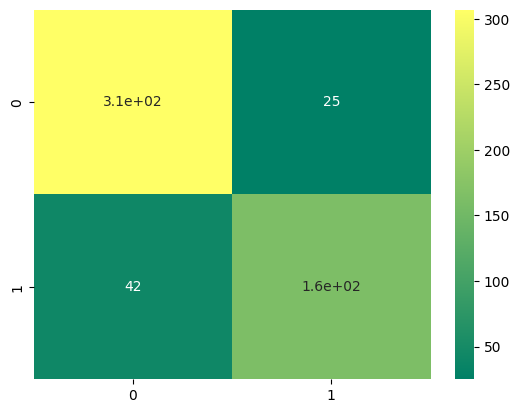

In [31]:
lr_clf = LogisticRegression(random_state=42)

model_accuracy(lr_clf,X_train,X_test,y_train,y_test)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       332
           1       0.86      0.77      0.81       205

    accuracy                           0.86       537
   macro avg       0.86      0.84      0.85       537
weighted avg       0.86      0.86      0.86       537



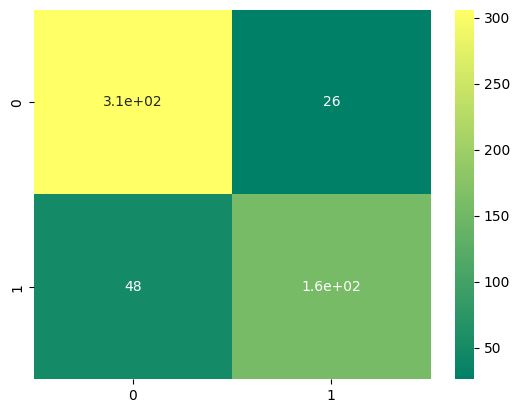

In [32]:
nb_clf = BernoulliNB()

model_accuracy(nb_clf,X_train,X_test,y_train,y_test)

#### Decision Tree Classifier

In [33]:
dt = DecisionTreeClassifier()

params_dt = {
'min_samples_split': range(1,10),
'criterion':['gini','entropy'],
'max_depth': range(1,10),
'min_samples_leaf': range(1,5)
}
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dt,
param_grid=params_dt,
scoring= 'r2',
cv=5,
n_jobs=-1)

grid_dt.fit(X_train, y_train)

# Extract best model from 'grid_dt'
best_modelDT = grid_dt.best_params_

In [34]:
DT_final = DecisionTreeClassifier(**best_modelDT)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       332
           1       0.89      0.77      0.82       205

    accuracy                           0.88       537
   macro avg       0.88      0.85      0.86       537
weighted avg       0.88      0.88      0.87       537



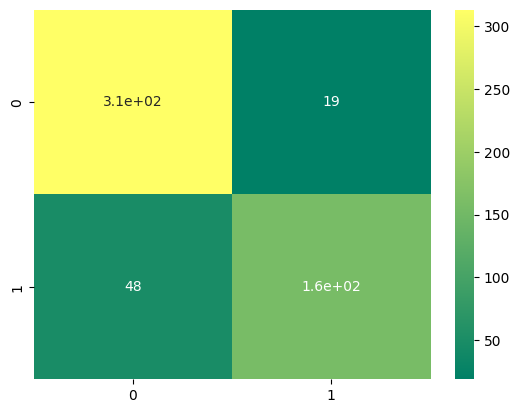

In [35]:
model_accuracy(DT_final,X_train,X_test,y_train,y_test)

#### RandomForest Classifier

In [37]:
rf_model = RandomForestClassifier()


# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20,40,50,100,150],
    max_depth=[5, 10, 15],
    min_samples_split=[2, 4,5],
    criterion = ['gini', 'entropy'],
#     max_features= ['auto', 'sqrt', 'log2']
)

# search
rf_clf = GridSearchCV(rf_model, rf_param_grid,
                   scoring='r2', cv=5, n_jobs = -1,verbose=1)

rf_clf.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 4, 5],
                         'n_estimators': [10, 20, 40, 50, 100, 150]},
             scoring='r2', verbose=1)

In [38]:
best_modelRF = rf_clf.best_params_

In [39]:
rf_final = RandomForestClassifier(**best_modelRF)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       332
           1       0.91      0.85      0.88       205

    accuracy                           0.91       537
   macro avg       0.91      0.90      0.90       537
weighted avg       0.91      0.91      0.91       537



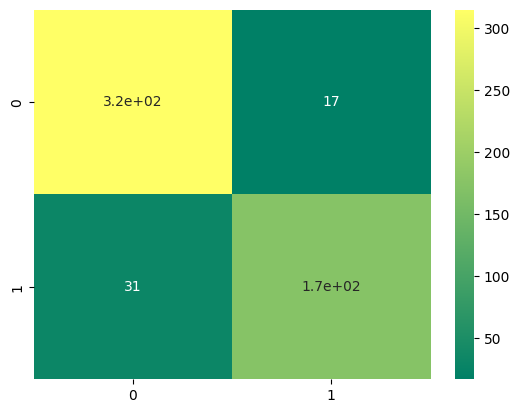

In [40]:
model_accuracy(rf_final,X_train,X_test,y_train,y_test)

#### XGBoost Classifier

In [41]:
param_dist = {
        'n_estimators':range(50,150,5),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,1,25),
        'subsample':np.linspace(0.1,0.9,25),
        'colsample_bytree':np.linspace(0.3,0.8,20),
        'min_child_weight':range(1,9,1),
        'gamma': [0, 0.2,0.25, 0.3,0.35, 0.5, 1.0]

        }


xgbr = XGBClassifier()
XGB_Model = RandomizedSearchCV(xgbr,
                   param_dist,
                   scoring='r2',
                   verbose=1,
                    cv = 5,
                    n_iter=125,
                    n_jobs = -1)
XGB_Model.fit(X_train, y_train)
print("Best parameters:", XGB_Model.best_params_)

best_modelXGB = XGB_Model.best_params_



Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best parameters: {'subsample': 0.7999999999999999, 'n_estimators': 95, 'min_child_weight': 2, 'max_depth': 2, 'learning_rate': 0.62875, 'gamma': 0, 'colsample_bytree': 0.3789473684210526}


In [42]:
xgb_final = XGBClassifier(**best_modelXGB)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       332
           1       0.90      0.84      0.87       205

    accuracy                           0.90       537
   macro avg       0.90      0.89      0.89       537
weighted avg       0.90      0.90      0.90       537



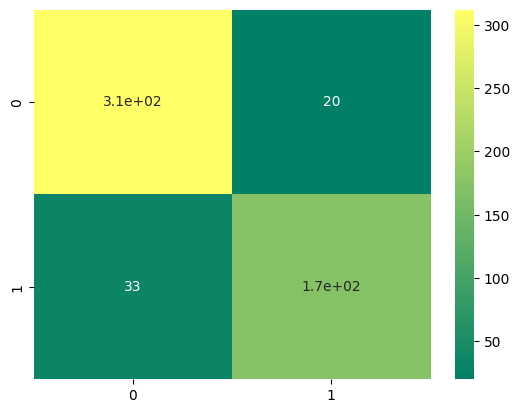

In [43]:
model_accuracy(xgb_final,X_train,X_test,y_train,y_test)